In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns
import math
from math import radians, sin, cos, sqrt
import os
import geopandas as gpd
import psycopg2
import ast
import matplotlib.pyplot as plt
import datetime
from psycopg2 import sql
from psycopg2.extras import Json
from shapely.geometry import LineString, mapping, box, Polygon, Point
from shapely import wkt
from shapely.wkb import loads
import shapely
import json
from myutil import *
import scipy
import myutil
import pickle

from geopy.distance import great_circle
from scipy.spatial import KDTree

#from pykdtree.kdtree import KDTree
import pykdtree
import rtree 
import pyqtree 
from quads import QuadTree
from pygeos import STRtree

d:\NewOne\UQ\INFS4205\assignment\taxi_trajectory\venv\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\Acer\AppData\Local\Temp\ipykernel_20372\4107898241.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https:

## Import data into pandas

In [2]:
df = pd.read_csv("final_data.csv")

In [17]:
df.shape

(999998, 15)

In [3]:
df['trip_id'].nunique()

999998

Find the entire space for all trips (Use to create Quad-Tree or Point-quad tree)

In [49]:
minx_entire = -8
maxx_entire = -9
miny_entire = 42
maxy_entire = 39
for line in df['polyline']:
    myline = LineString(ast.literal_eval(line))
    x1, y1, x2, y2 = myline.bounds
    if (x1 < minx_entire):
        minx_entire = x1
    if (y1 < miny_entire):
        miny_entire = y1
    if (x2 > maxx_entire):
        maxx_entire = x2
    if (y1 > maxy_entire):
        maxy_entire = y2

In [50]:
print("minx_entire:", minx_entire)
print("miny_entire:", miny_entire)
print("maxx_entire:", maxx_entire)
print("maxy_entire", maxy_entire)

minx_entire: -9.33309
miny_entire: 38.564424
maxx_entire: -6.273549
maxy_entire 42.051402


In [13]:
# bounding box for entire map -> this is also the original space for quadtree
create_map_with_bb(-9.33309, 38.564424, -6.273549, 42.051402)

## Test connection and query

In [3]:
try:
    # connect to the database
    connection = psycopg2.connect(
    host="localhost",
    port="5432",
    dbname="taxi_trajectory",
    user="postgres",
    password="123456"
    )
    cursor = connection.cursor()
    print("Connected!")
except print(0):
    print("Connect error!")



Connected!


In [11]:
# close connection
if connection:
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed")

PostgreSQL connection is closed


In [21]:
# test query
postgreSQL_select_Query = "select * from taxi_trips fetch first 100 rows only"
cursor.execute(postgreSQL_select_Query)
records = cursor.fetchall()

In [22]:
records[9]

(1390285403620000395,
 'A',
 45419,
 None,
 20000395,
 1390285403,
 'A',
 '[[-8.638515,41.171058],[-8.638029,41.170446],[-8.636499,41.169006],[-8.636418,41.168943],[-8.636247,41.168826],[-8.637246,41.168232],[-8.638452,41.166792],[-8.639496,41.166009],[-8.640477,41.165964],[-8.64045,41.167413],[-8.638767,41.169528],[-8.63496,41.171301],[-8.630343,41.172309],[-8.626311,41.172993],[-8.621937,41.173416],[-8.617023,41.173902],[-8.612424,41.174451],[-8.608113,41.173371],[-8.603991,41.171463],[-8.599437,41.171202],[-8.59491,41.171742],[-8.591571,41.16969],[-8.588142,41.167602],[-8.584713,41.166513],[-8.582022,41.164443],[-8.581545,41.161239],[-8.582787,41.15844],[-8.583282,41.155704],[-8.582283,41.153571],[-8.582562,41.152554],[-8.582409,41.151996],[-8.5824,41.151951],[-8.582346,41.151789],[-8.582589,41.151249],[-8.583642,41.150682],[-8.58393,41.149647],[-8.584236,41.148657],[-8.584533,41.147811],[-8.585055,41.146821],[-8.585325,41.146749],[-8.587071,41.147325],[-8.586387,41.147874],[-8.5861

In [ ]:
#
#SELECT ST_ASTEXT(ST_OrientedEnvelope(geom))
#FROM taxi_trips
#WHERE trip_id = 1382248506620000167

#POLYGON((-8.616221659246067 41.15813777073927,
# -8.61285046660335 41.15333618420891,
# -8.582385807357264 41.17472541346959,
# -8.585756999999974 41.179526999999986,
# -8.616221659246067 41.15813777073927))

In [18]:
print(myutil.get_bounding_box1(records[9][7]))
print(LineString(ast.literal_eval(records[9][7])).bounds)

[[-8.613306, 41.153985], [-8.585703, 41.179527]]
(-8.613306, 41.153985, -8.585703, 41.179527)


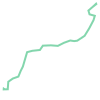

In [20]:
LineString(ast.literal_eval(records[9][7]))

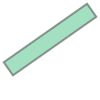

In [21]:
get_mpr_coordiantes1(records[9][7])

In [15]:
print(get_mpr_coordiantes1(records[9][7]))
type(get_mpr_coordiantes1(records[9][7]))

POLYGON ((-8.644711861774049 41.15171235342053, -8.64381675687278 41.13983991808169, -8.611740289276725 41.14225827645058, -8.612635394177993 41.15413071178941, -8.644711861774049 41.15171235342053))


shapely.geometry.polygon.Polygon

In [22]:
# with the minimum perimeter 4-corners polygon bounding box
# but I cant import to rtree library because of unsupported parameters :(((((((
create_map3(records[9][7])

In [25]:
# with rectangle minimum bounding box
myutil.create_map2(records[9][7])

# Creating Index

In [5]:
# get ids, timestamps and geoms from the database
query = "SELECT trip_id, timestamp, geom FROM taxi_trips"
cursor.execute(query)
rows = cursor.fetchall()

In [6]:
len(rows)

999998

## R-Tree Index

In [7]:
# Create R-tree index
p = rtree.index.Property()
p.dimension = 3  # Three dimensions: x, y (bounding box) and timestamp
myrtree = rtree.index.Index(properties=p)

Note: The coordinate ordering for all functions are sensitive the the index’s interleaved data member. If interleaved is False, the coordinates must be in the form [xmin, xmax, ymin, ymax, …, …, kmin, kmax]. If interleaved is True, the coordinates must be in the form [xmin, ymin, …, kmin, xmax, ymax, …, kmax]. 

In [8]:
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, geom_wkt = row
    geom = loads(geom_wkt)

    # Get bounds of LineString
    minx, miny, maxx, maxy = geom.bounds

    bounds = (minx, miny, timestamp,
              maxx, maxy, timestamp + 15 * (len(list(geom.coords)) - 1))
    
    # Insert to R-tree index
    myrtree.insert(int(trip_id), bounds)
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
rtree_creation_time = t2 - t1

Execution time: 0:03:39.205171


In [9]:
myrtree.get_size()

999998

## KD-Tree Index

In [4]:
#Execute the query to retrieve the data
query = "SELECT trip_id, timestamp, geom FROM taxi_trips"
cursor.execute(query)
rows = cursor.fetchall()

In [5]:
"""
# This method support the search query more efficient, but it's not good for storing data because of the large number of points (more than 49 million points)
# Create a numpy array of points, timestamps, and ids
points = []
for row in rows:
    trip_id = row[0]
    timestamp = row[1]
    linestring = loads(row[2])
    point_array = myutil.linestring_to_points(linestring)
    i = 0
    for point in point_array:
        points.append((point[0], point[1], timestamp + (i * 15), trip_id))
        i += 1

# Create a numpy array of points, timestamps, and ids
points_array = np.array(points)

t1 = datetime.datetime.now()
# Create a kd-tree (k = 3) with the numpy array of points, timestamps, and ids
mykdtree = KDTree(points_array[:, :2])
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
"""

In [ ]:
list(loads(rows[0][2]).coords)

In [10]:
# More suitable KD-tree for storage
points = []
t1 = datetime.datetime.now()
for row in rows:
    trip_id = row[0]
    timestamp = row[1]
    geom = loads(row[2])
    points.append((geom.bounds[0], geom.bounds[1], timestamp, geom.bounds[2], geom.bounds[3], timestamp + 15 * (len(list(geom.coords)) - 1), trip_id))
        

# Create a numpy array of points, timestamps, and ids
points_array = np.array(points)

# Create a kd-tree (k = 6) with minx, miny, start_timestamp, maxx, maxy, end_timestamps
mykdtree = KDTree(points_array[:, :6])
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
kdtree_creation_time = t2 - t1

Execution time: 0:02:20.706024


In [10]:
points_array[0, :6]

array([-8.67049200e+00,  4.11686550e+01,  1.37662377e+09, -8.62455600e+00,
        4.12388100e+01,  1.37662576e+09])

## Point-Quad Tree Index

In [5]:
#Execute the query to retrieve the data
query = "SELECT trip_id, timestamp, geom FROM taxi_trips"
cursor.execute(query)
rows = cursor.fetchall()

The entire space found from the code above <br>
minx_entire: -9.33309 <br>
miny_entire: 38.564424 <br>
maxx_entire: -6.273549 <br>
maxy_entire 42.051402

In [11]:
# use pyqtree library because of intersect() function for task1
mypqtree = pyqtree.Index(bbox=(-9.33309, 38.564424, -6.273549, 42.051402))

In [6]:
"""# This implementation is correct, 
# however, when I tried running this, my computer was crashed because of lot of points and my laptop's low performance :(
# I would change the implementation following the code below
points = []
for row in rows:
    trip_id = row[0]
    timestamp = row[1]
    linestring = loads(row[2])
    point_array = myutil.linestring_to_points(linestring)
    i = 0
    for point in point_array:
        points.append((point[0], point[1], timestamp + (i * 15), trip_id))
        i += 1

points_array = np.array(points)

# it was crashed because there're a lot of points generated from polylines
# -> a lot of node inserted to the tree -> my computer doesnt have enough temporary storage to process it :(
for point in points_array:
    point_obj = Point(point[0], point[1])
    timestamp = point[2]
    trip_id = point[3]
    mypqtree.insert((point_obj.x, point_obj.y, timestamp, trip_id), point_obj.bounds)
"""


In [12]:
# more suitable way
t1 = datetime.datetime.now()
for row in rows:
    trip_id, timestamp, geom_wkt = row
    geom = loads(geom_wkt)

    # Get bounds of LineString
    #minx, miny, maxx, maxy = geom.bounds
    
    mypqtree.insert((trip_id, timestamp), geom.bounds)

t2 = datetime.datetime.now()
print("Execution time:", t2 - t1,"seconds")
pqtree_creation_time = t2 - t1

Execution time: 0:03:48.672030 seconds


# Queries

## Task 1: Find all taxi trips in a given rectangular area and within a certain time (range) window

Explain my query: Given a searching rectangle bounding box (xmin, ymin, xmax, ymax) and a time range from {start_timestamp} to {end_timestamp}, find all the taxi went to that rectangle at that time. 

Note that the taxi must be inside the rectangle at the time. If the taxi's entire travel distance intersects with the rectangle, but at the time of approval, the taxi has not arrived or has passed the search area, this trajectory will not be counted.

### Set up searching area and time range

In [ ]:
# test
# year - month - day - hour - minute - second
start_date = datetime.datetime(2013, 7, 1, 10, 6, 50)
timestamp_startdate = int(start_date.timestamp())
print(timestamp_startdate)  # Output: 1670294400

# year - month - day - hour - minute - second
end_date = datetime.datetime(2013, 7, 1, 12, 0, 0)
timestamp_enddate = int(end_date.timestamp())
print(timestamp_enddate)  # Output: 1670294400

print(datetime.datetime.fromtimestamp(1372637210))  # 2013-07-01 10:06:50
print(datetime.datetime.fromtimestamp(1372637210).year) # 2013
print(datetime.datetime.fromtimestamp(1372637210).month) #7
print(datetime.datetime.fromtimestamp(1372637210).day) # 1
print(datetime.datetime.fromtimestamp(1372637210).hour) # 10
print(datetime.datetime.fromtimestamp(1372637210).minute) # 6
print(datetime.datetime.fromtimestamp(1372637210).second) # 50

Define searching area and time range

In [4]:
# max timestamp: 1393230201    min timestamp: 1372636853
# 2013-07-01 10:00:53            2014-02-24 18:23:21
# 41.1607172,-8.6424799  41.1636687,-8.627035
start_datetime = datetime.datetime(2013, 10, 1, 10, 0, 0)
end_datetime = datetime.datetime(2013, 10, 1, 11, 0, 0)
start_timestamp = int(start_datetime.timestamp())
end_timestamp = int(end_datetime.timestamp())
minx_search, miny_search, maxx_search, maxy_search = -8.6424799, 41.1607172, -8.627035, 41.1636687
print("start timestamp: ", start_timestamp, "         datetime:", start_datetime)
print("end timestamp: ", end_timestamp, "           datetime:", end_datetime)
print("Searching area: ", minx_search, miny_search, maxx_search, maxy_search)
print("Searching area: ", minx_search, ",", miny_search,",", maxx_search,",", maxy_search)
create_map_with_bb(minx_search, miny_search, maxx_search, maxy_search)

start timestamp:  1380585600          datetime: 2013-10-01 10:00:00
end timestamp:  1380589200            datetime: 2013-10-01 11:00:00
Searching area:  -8.6424799 41.1607172 -8.627035 41.1636687
Searching area:  -8.6424799 , 41.1607172 , -8.627035 , 41.1636687


### No index (from DB)

In [ ]:
# Traverse all coordinate pairs as points in a polyline query    
"""
WITH points AS (
    SELECT trip_id, (timestamp + generate_series(0, ST_NPoints(geom)-1)*15) AS ts, (ST_DumpPoints(geom)).geom AS point
    FROM taxi_trips
)
SELECT trip_id, ts, ST_X(point) AS lon, ST_Y(point) AS lat
FROM points;
"""


In [ ]:
"""
WITH points AS (
    SELECT trip_id, (timestamp + generate_series(0, ST_NPoints(geom)-1)*15) AS ts, (ST_DumpPoints(geom)).geom AS point
    FROM taxi_trips
)
SELECT trip_id, ts, ST_X(point) AS lon, ST_Y(point) AS lat, point
FROM points
WHERE ts BETWEEN {} AND {}
AND ST_Within(point, ST_MakeEnvelope({}, {}, {}, {}, 4326))
""".format(start_timestamp, end_timestamp, minx_search, miny_search, maxx_search, maxy_search)

In [17]:
# get distinct trip_ids
task1_query_distinct = """
WITH points AS (
    SELECT trip_id, (timestamp + generate_series(0, ST_NPoints(geom)-1)*15) AS ts, (ST_DumpPoints(geom)).geom AS point
    FROM taxi_trips
)
SELECT DISTINCT trip_id
FROM points
WHERE ts BETWEEN {} AND {}
AND ST_Within(point, ST_MakeEnvelope({}, {}, {}, {}, 4326))
""".format(start_timestamp, end_timestamp, minx_search, miny_search, maxx_search, maxy_search)

In [18]:
t1 = datetime.datetime.now()
cursor.execute(task1_query_distinct)
t2 = datetime.datetime.now()
print("Execution time: ", t2 - t1)
db_query_time = t2 - t1
query1_result_db = cursor.fetchall()
print(len(query1_result_db))

Execution time:  0:00:23.558182
8


In [12]:
query1_result_db

[(1380585602620000625,),
 (1380585964620000621,),
 (1380586047620000022,),
 (1380586075620000431,),
 (1380586765620000529,),
 (1380587264620000067,),
 (1380587282620000263,),
 (1380587539620000617,)]

In [5]:
# Update query: created points table for faster query.
# The execution time will reduce (23s to 3s) but the amount of storage will increase.
task1_query_distinct2 = """SELECT DISTINCT trip_id
FROM points
WHERE ts BETWEEN {} AND {}
AND ST_Within(ST_SetSRID(ST_MakePoint(lon, lat), 4326), ST_MakeEnvelope({}, {}, {}, {}, 4326))
""".format(start_timestamp, end_timestamp, minx_search, miny_search, maxx_search, maxy_search)

In [6]:
t1 = datetime.datetime.now()
cursor.execute(task1_query_distinct2)
t2 = datetime.datetime.now()
print("Execution time: ", t2 - t1)
db_query_time = t2 - t1
query1_result_db = cursor.fetchall()
print(len(query1_result_db))

Execution time:  0:00:03.558341
8


In [7]:
query1_result_db

[(1380585602620000625,),
 (1380585964620000621,),
 (1380586047620000022,),
 (1380586075620000431,),
 (1380586765620000529,),
 (1380587264620000067,),
 (1380587282620000263,),
 (1380587539620000617,)]

In [22]:
# check the returned results manually
create_map4(df['polyline'][df[df['trip_id'] == 1380587264620000067].index.to_list()[0]], [miny_search, minx_search], [maxy_search, maxx_search])

In [ ]:
list(df[df['trip_id'].isin([x[0] for x in query1_result_db])]['polyline'])

In [23]:
# multi lines
create_map_multi_lines(list(df[df['trip_id'].isin([x[0] for x in query1_result_db])]['polyline']), [miny_search, minx_search], [maxy_search, maxx_search])

### R-tree Task1 

In [47]:
query_bounds = (minx_search, miny_search, start_timestamp, maxx_search, maxy_search, end_timestamp)
t1 = datetime.datetime.now()
retured_trip_ids_rtree = myrtree.intersection(query_bounds)
t2 = datetime.datetime.now()
print("Execution time:", t2-t1)
retured_trip_ids_rtree = list(retured_trip_ids_rtree)

Execution time: 0:00:00.000997


In [49]:
retured_trip_ids_rtree

[1380586676620000467,
 1380586747620000589,
 1380587440620000424,
 1380587539620000617,
 1380587217620000577,
 1380587264620000067,
 1380588599620000173,
 1380587282620000263,
 1380587187620000066,
 1380586765620000529,
 1380584990620000263,
 1380585443620000598,
 1380585964620000621,
 1380585602620000625,
 1380586047620000022,
 1380586100620000233,
 1380586075620000431,
 1380585376620000612,
 1380584873620000308]

In [94]:
# This trip really didn't enter the search area -> this is a drawback of R-tree. 
# If the perimeter bounding box is not optimized, it will be worse
# So I need to linearly scan all the records from given trip_ids above to make sure that the output is same as from the database.
create_map4(df['polyline'][df[df['trip_id'] == 1380586676620000467].index.to_list()[0]], [miny_search, minx_search], [maxy_search, maxx_search])

In [151]:
filtered_trip_ids = set()
trip_id_idx_list = []

for trip_id in retured_trip_ids_rtree:
   trip_id_idx_list.append(df[df['trip_id'] == trip_id].index[0])

t1 = datetime.datetime.now()
for idx in trip_id_idx_list:
    i = 0
    for coord in shapely.wkt.loads(df.geom[idx]).coords:
        current_time_at_point = df.timestamp[idx] + (i * 15)
        if ((current_time_at_point >= start_timestamp) & (current_time_at_point <= end_timestamp) 
            & (coord[0] >= minx_search) & (coord[1] >= miny_search) 
            & (coord[0] <= maxx_search) & (coord[1] <= maxy_search)):
            filtered_trip_ids.add(df.trip_id[idx])
        i += 1
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
filtered_trip_ids


Execution time: 0:00:00.025932


{1380585602620000625,
 1380585964620000621,
 1380586047620000022,
 1380586075620000431,
 1380586765620000529,
 1380587264620000067,
 1380587282620000263,
 1380587539620000617}

In [148]:
# just simplify the code above
filtered_trip_ids_2 = {df.trip_id[idx] for idx in [df[df['trip_id'] == trip_id].index[0] for trip_id in retured_trip_ids_rtree] 
                       for i, coord in enumerate(shapely.wkt.loads(df.geom[idx]).coords) 
                       if ((df.timestamp[idx] + (i * 15)) >= start_timestamp) and ((df.timestamp[idx] + (i * 15)) <= end_timestamp) 
                       and (coord[0] >= minx_search) and (coord[1] >= miny_search) 
                       and (coord[0] <= maxx_search) and (coord[1] <= maxy_search)}

filtered_trip_ids_2


{1380585602620000625,
 1380585964620000621,
 1380586047620000022,
 1380586075620000431,
 1380586765620000529,
 1380587264620000067,
 1380587282620000263,
 1380587539620000617}

In [21]:
# I just combine all things above together to calculate execution time
def query_myrtree_time(query_bounds):
    t1 = datetime.datetime.now()
    retured_trip_ids_rtree = myrtree.intersection(query_bounds)
    t2 = datetime.datetime.now()
    print("myrtree intersection Execution time:", t2 - t1)
    rtree_query_time = t2-t1
    
    retured_trip_ids_rtree = list(retured_trip_ids_rtree)

    filtered_trip_ids = set()
    t1 = datetime.datetime.now()
    for trip_id in retured_trip_ids_rtree:
        idx = df[df['trip_id'] == trip_id].index[0]
        coords = shapely.wkt.loads(df.geom[idx]).coords
        time_stamps = [df.timestamp[idx] + (i * 15) for i in range(len(coords))]
        within_bounds = [(time_stamps[i] >= query_bounds[2] and time_stamps[i] <= query_bounds[5]) 
                         and (coords[i][0] >= query_bounds[0] and coords[i][1] >= query_bounds[1]) 
                         and (coords[i][0] <= query_bounds[3] and coords[i][1] <= query_bounds[4]) 
                         for i in range(len(coords))]
        if any(within_bounds):
            filtered_trip_ids.add(df.trip_id[idx])
    t2 = datetime.datetime.now()
    print("Filtered results Execution time:", t2 - t1)
    rtree_query_time += t2 - t1
    print("Total query time:", rtree_query_time)
    return filtered_trip_ids, rtree_query_time

In [22]:
rtree_filtered_trip_ids, rtree_query_time = query_myrtree_time((minx_search, miny_search, start_timestamp, maxx_search, maxy_search, end_timestamp))

myrtree intersection Execution time: 0:00:00.042894
Filtered results Execution time: 0:00:00.119715
Total query time: 0:00:00.162609


In [23]:
# The result looks good.
print(rtree_filtered_trip_ids)
print(rtree_query_time)

{1380587264620000067, 1380587282620000263, 1380587539620000617, 1380585964620000621, 1380586075620000431, 1380586765620000529, 1380585602620000625, 1380586047620000022}
0:00:00.162609


### Point-quad tree Task1

In [37]:
retured_trip_ids_pqtree = []
t1 = datetime.datetime.now()
for item in mypqtree.intersect((minx_search, miny_search, maxx_search, maxy_search)):
    if  item[1] >= start_timestamp and item[1] <= end_timestamp:
        retured_trip_ids_pqtree.append(item[0])
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
retured_trip_ids_pqtree

Execution time: 0:00:00.917516


[1380586047620000022,
 1380587187620000066,
 1380586676620000467,
 1380585602620000625,
 1380587264620000067,
 1380587539620000617,
 1380585964620000621,
 1380586765620000529,
 1380586100620000233,
 1380586075620000431,
 1380587440620000424,
 1380588599620000173,
 1380587282620000263,
 1380586747620000589,
 1380587217620000577]

In [38]:
filtered_trip_ids_qtree = set()
trip_id_idx_list = []

for trip_id in retured_trip_ids_pqtree:
   trip_id_idx_list.append(df[df['trip_id'] == trip_id].index[0])
# filter again, make sure the taxi went to the rectangle in a searching time range
t1 = datetime.datetime.now()
for idx in trip_id_idx_list:
    i = 0
    for coord in shapely.wkt.loads(df.geom[idx]).coords:
        current_time_at_point = df.timestamp[idx] + (i * 15)
        if ((current_time_at_point >= start_timestamp) & (current_time_at_point <= end_timestamp) 
            & (coord[0] >= minx_search) & (coord[1] >= miny_search) 
            & (coord[0] <= maxx_search) & (coord[1] <= maxy_search)):
            filtered_trip_ids_qtree.add(df.trip_id[idx])
        i += 1
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
filtered_trip_ids_qtree

Execution time: 0:00:00.017949


{1380585602620000625,
 1380585964620000621,
 1380586047620000022,
 1380586075620000431,
 1380586765620000529,
 1380587264620000067,
 1380587282620000263,
 1380587539620000617}

In [29]:
# Combine all the code above together to calculate total query time
def query_mypqtree_time():
    retured_trip_ids_pqtree = []
    t1 = datetime.datetime.now()
    for item in mypqtree.intersect((minx_search, miny_search, maxx_search, maxy_search)):
        if  item[1] >= start_timestamp and item[1] <= end_timestamp:
            retured_trip_ids_pqtree.append(item[0])
    t2 = datetime.datetime.now()
    print("Execution time:", t2 - t1)
    pqtree_query_time = t2 - t1
    retured_trip_ids_pqtree
    
    filtered_trip_ids_qtree = set()
    trip_id_idx_list = []

    for trip_id in retured_trip_ids_pqtree:
        trip_id_idx_list.append(df[df['trip_id'] == trip_id].index[0])
        
    # filter again, make sure the taxi went to the rectangle in a searching time range
    t1 = datetime.datetime.now()
    for idx in trip_id_idx_list:
        i = 0
        for coord in shapely.wkt.loads(df.geom[idx]).coords:
            current_time_at_point = df.timestamp[idx] + (i * 15)
            if ((current_time_at_point >= start_timestamp) & (current_time_at_point <= end_timestamp) 
                & (coord[0] >= minx_search) & (coord[1] >= miny_search) 
                & (coord[0] <= maxx_search) & (coord[1] <= maxy_search)):
                filtered_trip_ids_qtree.add(df.trip_id[idx])
            i += 1
    t2 = datetime.datetime.now()
    print("Execution time:", t2 - t1)
    pqtree_query_time += t2 - t1
    return filtered_trip_ids_qtree, pqtree_query_time

In [30]:
rtree_filtered_trip_ids, pqtree_query_time = query_mypqtree_time()
print(rtree_filtered_trip_ids)
print("Query execution time:", pqtree_query_time)

Execution time: 0:00:01.213236
Execution time: 0:00:00.013980
{1380587264620000067, 1380587282620000263, 1380587539620000617, 1380585964620000621, 1380586075620000431, 1380585602620000625, 1380586765620000529, 1380586047620000022}
Query execution time: 0:00:01.227216


In [31]:
# Check the result manually to ensure the correctness
create_map4(df['polyline'][df[df['trip_id'] == 1380587282620000263].index.to_list()[0]], [miny_search, minx_search], [maxy_search, maxx_search])

### KD-tree Task1

In [81]:
# Query the kd-tree for all points within the rectangle
# Here, it's hard to determine the "right" radius of query_ball_point for all cases, we need to do further analysis to choose.
# In this case, I just randomly choose the length of point array to be the radius.
t1 = datetime.datetime.now()
indices = mykdtree.query_ball_point(np.array([minx_search, miny_search, start_timestamp, maxx_search, maxy_search, end_timestamp]), r=len(points_array))
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
# Extract the trip ids of the points within the rectangle and between the timestamps
retured_trip_ids_kdtree = set(points_array[indices, 6][(points_array[indices, 2] >= start_timestamp) & (points_array[indices, 2] <= end_timestamp)])


Execution time: 0:00:00.003987


In [82]:
print(len(indices))
print(len(retured_trip_ids_kdtree))

75935
81


In [83]:
filtered_trip_ids = set()
trip_id_idx_list = []

for trip_id in retured_trip_ids_kdtree:
   trip_id_idx_list.append(df[df['trip_id'] == trip_id].index[0])

t1 = datetime.datetime.now()
for idx in trip_id_idx_list:
    i = 0
    for coord in shapely.wkt.loads(df.geom[idx]).coords:
        current_time_at_point = df.timestamp[idx] + (i * 15)
        if ((current_time_at_point >= start_timestamp) & (current_time_at_point <= end_timestamp) 
            & (coord[0] >= minx_search) & (coord[1] >= miny_search) 
            & (coord[0] <= maxx_search) & (coord[1] <= maxy_search)):
            filtered_trip_ids.add(df.trip_id[idx])
        i += 1
t2 = datetime.datetime.now()
print("Execution time:", t2 - t1)
filtered_trip_ids


Execution time: 0:00:00.068775


{1380585602620000625,
 1380585964620000621,
 1380586047620000022,
 1380586075620000431,
 1380586765620000529,
 1380587264620000067,
 1380587282620000263,
 1380587539620000617}

In [32]:
# combine together to calculate total query execution time
def query_mykdtree_time():

    # Query the kd-tree for all points within the rectangle
    t1 = datetime.datetime.now()
    indices = mykdtree.query_ball_point(np.array([minx_search, miny_search, start_timestamp, maxx_search, maxy_search, end_timestamp]), r=len(points_array))
    t2 = datetime.datetime.now()
    print("mykdtree intersection Execution time:", t2 - t1)
    kdtree_exec_time = t2 - t1

    # Extract the trip ids of the points within the rectangle and between the timestamps
    returned_trip_ids_kdtree = set(points_array[indices, 6][(points_array[indices, 2] >= start_timestamp) & (points_array[indices, 2] <= end_timestamp)])

    # Filter the trip ids
    filtered_trip_ids = set()
    trip_id_idx_list = []

    for trip_id in returned_trip_ids_kdtree:
        trip_id_idx_list.append(df[df['trip_id'] == trip_id].index[0])

    t1 = datetime.datetime.now()
    for idx in trip_id_idx_list:
        i = 0
        for coord in shapely.wkt.loads(df.geom[idx]).coords:
            current_time_at_point = df.timestamp[idx] + (i * 15)
            if ((current_time_at_point >= start_timestamp) & (current_time_at_point <= end_timestamp)
                & (coord[0] >= minx_search) & (coord[1] >= miny_search)
                & (coord[0] <= maxx_search) & (coord[1] <= maxy_search)):
                filtered_trip_ids.add(df.trip_id[idx])
            i += 1
    t2 = datetime.datetime.now()
    filter_exec_time = t2 - t1
    print("Filtered results Execution time:", t2 - t1)

    total_query_time = kdtree_exec_time + filter_exec_time
    print("Total query time:", total_query_time)
    return filtered_trip_ids, total_query_time 

In [33]:
kdtree_filtered_trip_ids, kdtree_query_time= query_mykdtree_time()
print(kdtree_filtered_trip_ids)
print("Total query execution time:", kdtree_query_time)

mykdtree intersection Execution time: 0:00:00.046023
Filtered results Execution time: 0:00:00.057797
Total query time: 0:00:00.103820
{1380587264620000067, 1380587282620000263, 1380587539620000617, 1380585964620000621, 1380586075620000431, 1380585602620000625, 1380586765620000529, 1380586047620000022}
Total query execution time: 0:00:00.103820


# Compare performance

## Creation time

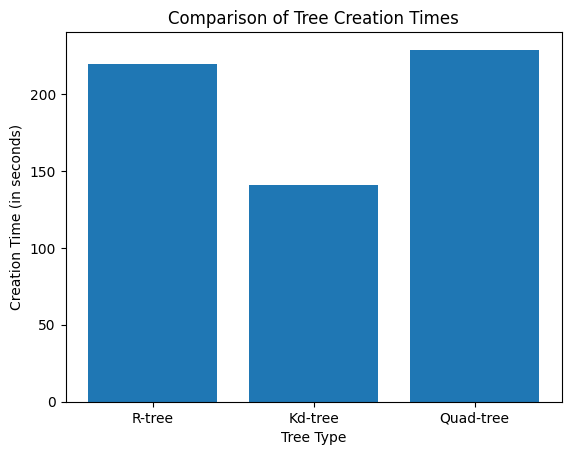

In [13]:
creation_time_all = {'R-tree': rtree_creation_time.total_seconds(), 
                     'Kd-tree': kdtree_creation_time.total_seconds(), 
                     'Quad-tree': pqtree_creation_time.total_seconds()}

plt.bar(creation_time_all.keys(), creation_time_all.values())
plt.xlabel('Tree Type')
plt.ylabel('Creation Time (in seconds)')
plt.title('Comparison of Tree Creation Times')
plt.show()

## Query task 1 execution time

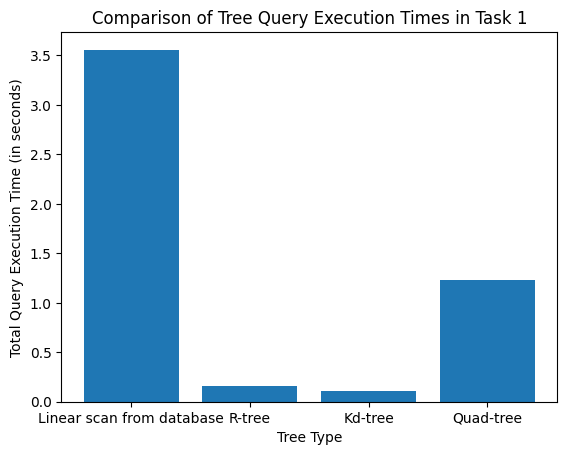

In [10]:
query_time_all = {'Linear scan from database': db_query_time.total_seconds(),
                  'R-tree': rtree_query_time.total_seconds(), 
                  'Kd-tree': kdtree_query_time.total_seconds(), 
                  'Quad-tree': pqtree_query_time.total_seconds()}

#query_time_all2 = {'Linear scan from database': 3.558341,
#                  'R-tree': 0.162609, 
#                  'Kd-tree': 0.103820, 
#                  'Quad-tree': 1.227216}

plt.bar(query_time_all.keys(), query_time_all.values())

plt.xlabel('Tree Type')
plt.ylabel('Total Query Execution Time (in seconds)')
plt.title('Comparison of Tree Query Execution Times in Task 1')
plt.show()